In [ ]:
#https://github.com/SherlockLiao
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torch.autograd import Variable
import os

In [2]:
if not os.path.exists('../img'):
    os.mkdir('../img')


def to_img(x):
    out = 0.5 * (x + 1)
    out = out.clamp(0, 1)
    out = out.view(-1, 1, 28, 28)
    return out

In [3]:
batch_size = 128
num_epoch = 250
z_dimension = 100

In [4]:
# Image processing
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# MNIST dataset
mnist = datasets.MNIST(
    root='./data/MNIST', train=True, transform=img_transform, download=True)
# Data loader
dataloader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True)

In [5]:
# Discriminator
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2), nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, x):
        x = self.dis(x)
        return x


# Generator
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256), nn.ReLU(True), nn.Linear(256, 784), nn.Tanh())

    def forward(self, x):
        x = self.gen(x)
        return x

In [6]:
D = discriminator()
G = generator()
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0003)

In [16]:
# You can choose one of this 2 strategies
# Load the whole model
#G = torch.load('./generator.pth')
#D = torch.load('./discriminator.pth')

# If you just want to load the weights 
#G.load_state_dict(torch.load('./generator_weights.pth'))
#D.load_state_dict(torch.load('./discriminator_weights.pth'))

In [2]:
# Start training
for epoch in range(num_epoch):
    for i, (img, _) in enumerate(dataloader):
        num_img = img.size(0)
        # =================train discriminator
        img = img.view(num_img, -1)
        real_img = Variable(img).cuda()
        real_label = Variable(torch.ones(num_img)).cuda()
        fake_label = Variable(torch.zeros(num_img)).cuda()

        # compute loss of real_img
        real_out = D(real_img)
        d_loss_real = criterion(real_out, real_label)
        real_scores = real_out  # closer to 1 means better

        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension)).cuda()
        fake_img = G(z)
        fake_out = D(fake_img)
        d_loss_fake = criterion(fake_out, fake_label)
        fake_scores = fake_out  # closer to 0 means better

        # bp and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # ===============train generator
        # compute loss of fake_img
        z = Variable(torch.randn(num_img, z_dimension)).cuda()
        fake_img = G(z)
        output = D(fake_img)
        g_loss = criterion(output, real_label)

        # bp and optimize
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], d_loss: {:.6f}, g_loss: {:.6f} '
                  'D real: {:.6f}, D fake: {:.6f}'.format(
                      epoch, num_epoch, d_loss.data[0], g_loss.data[0],
                      real_scores.data.mean(), fake_scores.data.mean()))
    if epoch == 0:
        real_images = to_img(real_img.cpu().data)
        save_image(real_images, './img/real_images.png')

    fake_images = to_img(fake_img.cpu().data)
    save_image(fake_images, './img/fake_images-{}.png'.format(epoch + 1))

/home/matiaca2/.conda/envs/python3ML/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [0/250], d_loss: 0.137261, g_loss: 3.566060 D real: 0.967653, D fake: 0.097373
Epoch [0/250], d_loss: 0.050964, g_loss: 3.981411 D real: 0.988734, D fake: 0.038563
Epoch [0/250], d_loss: 0.100087, g_loss: 5.400046 D real: 0.983755, D fake: 0.075788
Epoch [0/250], d_loss: 0.050921, g_loss: 4.259403 D real: 0.990951, D fake: 0.040522


/home/matiaca2/.conda/envs/python3ML/lib/python3.6/site-packages/torch/nn/functional.py:1168: UserWarning: Using a target size (torch.Size([96])) that is different to the input size (torch.Size([96, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/250], d_loss: 0.159212, g_loss: 5.733728 D real: 0.979441, D fake: 0.077053
Epoch [1/250], d_loss: 0.050471, g_loss: 7.486523 D real: 0.997853, D fake: 0.045646
Epoch [1/250], d_loss: 0.078796, g_loss: 6.898526 D real: 0.990176, D fake: 0.064003
Epoch [1/250], d_loss: 0.059011, g_loss: 7.565337 D real: 0.984088, D fake: 0.034777
Epoch [2/250], d_loss: 0.095435, g_loss: 6.623299 D real: 0.970282, D fake: 0.030358
Epoch [2/250], d_loss: 0.259135, g_loss: 7.429771 D real: 0.864966, D fake: 0.031773
Epoch [2/250], d_loss: 0.218529, g_loss: 7.341111 D real: 0.886666, D fake: 0.055154
Epoch [2/250], d_loss: 0.163175, g_loss: 6.844638 D real: 0.947206, D fake: 0.062748
Epoch [3/250], d_loss: 0.313629, g_loss: 4.645431 D real: 0.890185, D fake: 0.114459
Epoch [3/250], d_loss: 1.244382, g_loss: 6.551472 D real: 0.727715, D fake: 0.241217
Epoch [3/250], d_loss: 0.605381, g_loss: 4.605526 D real: 0.875337, D fake: 0.225796
Epoch [3/250], d_loss: 0.397572, g_loss: 3.542303 D real: 0.88694

Epoch [25/250], d_loss: 0.160513, g_loss: 3.941728 D real: 0.937023, D fake: 0.053747
Epoch [25/250], d_loss: 0.252166, g_loss: 4.164970 D real: 0.923725, D fake: 0.097933
Epoch [25/250], d_loss: 0.362226, g_loss: 3.893867 D real: 0.920495, D fake: 0.165009
Epoch [25/250], d_loss: 0.390984, g_loss: 2.964552 D real: 0.931473, D fake: 0.201675
Epoch [26/250], d_loss: 0.460680, g_loss: 4.146298 D real: 0.835659, D fake: 0.092159
Epoch [26/250], d_loss: 0.300562, g_loss: 3.987523 D real: 0.900452, D fake: 0.084869
Epoch [26/250], d_loss: 0.277820, g_loss: 3.418995 D real: 0.900642, D fake: 0.082134
Epoch [26/250], d_loss: 0.361357, g_loss: 3.470265 D real: 0.926399, D fake: 0.171078
Epoch [27/250], d_loss: 0.230670, g_loss: 3.708797 D real: 0.938058, D fake: 0.092946
Epoch [27/250], d_loss: 0.248937, g_loss: 3.400390 D real: 0.934068, D fake: 0.096952
Epoch [27/250], d_loss: 0.365723, g_loss: 4.961445 D real: 0.900709, D fake: 0.052901
Epoch [27/250], d_loss: 0.347790, g_loss: 3.708435 D r

Epoch [49/250], d_loss: 0.438910, g_loss: 3.646937 D real: 0.869666, D fake: 0.105522
Epoch [49/250], d_loss: 0.367228, g_loss: 3.444818 D real: 0.839461, D fake: 0.065318
Epoch [49/250], d_loss: 0.532505, g_loss: 2.820355 D real: 0.805965, D fake: 0.155072
Epoch [49/250], d_loss: 0.720126, g_loss: 2.768393 D real: 0.847378, D fake: 0.262832
Epoch [50/250], d_loss: 0.389007, g_loss: 2.999171 D real: 0.863760, D fake: 0.103882
Epoch [50/250], d_loss: 0.779504, g_loss: 2.689550 D real: 0.817291, D fake: 0.238796
Epoch [50/250], d_loss: 0.539587, g_loss: 2.646402 D real: 0.823501, D fake: 0.162515
Epoch [50/250], d_loss: 0.555249, g_loss: 3.714748 D real: 0.857535, D fake: 0.156657
Epoch [51/250], d_loss: 0.534042, g_loss: 2.683308 D real: 0.823715, D fake: 0.154888
Epoch [51/250], d_loss: 0.523499, g_loss: 3.405952 D real: 0.804488, D fake: 0.121960
Epoch [51/250], d_loss: 0.420607, g_loss: 2.351193 D real: 0.860764, D fake: 0.139294
Epoch [51/250], d_loss: 0.752677, g_loss: 2.231166 D r

Epoch [73/250], d_loss: 0.522626, g_loss: 2.063337 D real: 0.804209, D fake: 0.166432
Epoch [73/250], d_loss: 0.788810, g_loss: 1.871302 D real: 0.768923, D fake: 0.243459
Epoch [73/250], d_loss: 0.743356, g_loss: 2.455112 D real: 0.672365, D fake: 0.100480
Epoch [73/250], d_loss: 0.871433, g_loss: 1.822202 D real: 0.765541, D fake: 0.289178
Epoch [74/250], d_loss: 0.694059, g_loss: 2.371771 D real: 0.733219, D fake: 0.185642
Epoch [74/250], d_loss: 0.868655, g_loss: 2.600687 D real: 0.699101, D fake: 0.218744
Epoch [74/250], d_loss: 0.770529, g_loss: 2.169956 D real: 0.740851, D fake: 0.236911
Epoch [74/250], d_loss: 0.676757, g_loss: 1.885599 D real: 0.801072, D fake: 0.250544
Epoch [75/250], d_loss: 0.699022, g_loss: 1.545247 D real: 0.788166, D fake: 0.241412
Epoch [75/250], d_loss: 0.888247, g_loss: 1.994289 D real: 0.779395, D fake: 0.309242
Epoch [75/250], d_loss: 0.603727, g_loss: 2.519207 D real: 0.776345, D fake: 0.154195
Epoch [75/250], d_loss: 0.657530, g_loss: 2.672972 D r

Epoch [97/250], d_loss: 0.828407, g_loss: 2.078732 D real: 0.743027, D fake: 0.303553
Epoch [97/250], d_loss: 0.734389, g_loss: 2.224743 D real: 0.723965, D fake: 0.194652
Epoch [97/250], d_loss: 0.888393, g_loss: 2.066956 D real: 0.691566, D fake: 0.230523
Epoch [97/250], d_loss: 0.839167, g_loss: 1.811986 D real: 0.753943, D fake: 0.284335
Epoch [98/250], d_loss: 0.709733, g_loss: 1.587631 D real: 0.743007, D fake: 0.213906
Epoch [98/250], d_loss: 0.988594, g_loss: 1.572395 D real: 0.652343, D fake: 0.240147
Epoch [98/250], d_loss: 0.680950, g_loss: 1.811911 D real: 0.748666, D fake: 0.199330
Epoch [98/250], d_loss: 0.740255, g_loss: 2.037863 D real: 0.734778, D fake: 0.210027
Epoch [99/250], d_loss: 0.962688, g_loss: 2.317833 D real: 0.662787, D fake: 0.196029
Epoch [99/250], d_loss: 0.648773, g_loss: 2.079881 D real: 0.795775, D fake: 0.235535
Epoch [99/250], d_loss: 0.875383, g_loss: 1.941555 D real: 0.680310, D fake: 0.216296
Epoch [99/250], d_loss: 0.848753, g_loss: 2.030469 D r

Epoch [120/250], d_loss: 0.693676, g_loss: 1.824490 D real: 0.771739, D fake: 0.262256
Epoch [121/250], d_loss: 1.033417, g_loss: 1.537360 D real: 0.644254, D fake: 0.263244
Epoch [121/250], d_loss: 1.012001, g_loss: 2.004448 D real: 0.673310, D fake: 0.290086
Epoch [121/250], d_loss: 0.886161, g_loss: 2.275407 D real: 0.681895, D fake: 0.217922
Epoch [121/250], d_loss: 0.939440, g_loss: 1.801057 D real: 0.720234, D fake: 0.311989
Epoch [122/250], d_loss: 0.887078, g_loss: 1.615526 D real: 0.744488, D fake: 0.319551
Epoch [122/250], d_loss: 1.004139, g_loss: 1.549787 D real: 0.696546, D fake: 0.334799
Epoch [122/250], d_loss: 0.755522, g_loss: 1.590953 D real: 0.845240, D fake: 0.368382
Epoch [122/250], d_loss: 0.937040, g_loss: 1.718899 D real: 0.751897, D fake: 0.352213
Epoch [123/250], d_loss: 0.951607, g_loss: 2.085056 D real: 0.673507, D fake: 0.267421
Epoch [123/250], d_loss: 0.864044, g_loss: 2.023621 D real: 0.732208, D fake: 0.279719
Epoch [123/250], d_loss: 0.770689, g_loss: 

Epoch [144/250], d_loss: 1.010097, g_loss: 1.520146 D real: 0.610350, D fake: 0.245217
Epoch [144/250], d_loss: 0.944129, g_loss: 1.817154 D real: 0.668419, D fake: 0.273435
Epoch [145/250], d_loss: 0.793751, g_loss: 1.577804 D real: 0.738370, D fake: 0.300836
Epoch [145/250], d_loss: 1.091986, g_loss: 1.480539 D real: 0.648412, D fake: 0.315439
Epoch [145/250], d_loss: 0.780599, g_loss: 1.778369 D real: 0.742822, D fake: 0.270644
Epoch [145/250], d_loss: 0.885775, g_loss: 1.934648 D real: 0.655121, D fake: 0.244950
Epoch [146/250], d_loss: 0.883621, g_loss: 1.571062 D real: 0.696784, D fake: 0.287428
Epoch [146/250], d_loss: 0.853436, g_loss: 1.573298 D real: 0.801987, D fake: 0.355871
Epoch [146/250], d_loss: 0.925873, g_loss: 1.791671 D real: 0.670712, D fake: 0.271931
Epoch [146/250], d_loss: 1.278198, g_loss: 1.370642 D real: 0.675212, D fake: 0.418839
Epoch [147/250], d_loss: 0.748968, g_loss: 2.209674 D real: 0.694761, D fake: 0.207096
Epoch [147/250], d_loss: 0.939944, g_loss: 

Epoch [168/250], d_loss: 0.985623, g_loss: 1.449968 D real: 0.644851, D fake: 0.277618
Epoch [168/250], d_loss: 1.021784, g_loss: 1.340969 D real: 0.708347, D fake: 0.333232
Epoch [168/250], d_loss: 0.882161, g_loss: 1.650251 D real: 0.738057, D fake: 0.332294
Epoch [169/250], d_loss: 0.889667, g_loss: 1.601169 D real: 0.702267, D fake: 0.294749
Epoch [169/250], d_loss: 0.961402, g_loss: 1.611551 D real: 0.664693, D fake: 0.291251
Epoch [169/250], d_loss: 0.979374, g_loss: 1.355583 D real: 0.739636, D fake: 0.387027
Epoch [169/250], d_loss: 0.901171, g_loss: 1.617187 D real: 0.702112, D fake: 0.288919
Epoch [170/250], d_loss: 0.985982, g_loss: 1.452945 D real: 0.695042, D fake: 0.319756
Epoch [170/250], d_loss: 0.847945, g_loss: 1.711794 D real: 0.724056, D fake: 0.289939
Epoch [170/250], d_loss: 0.920447, g_loss: 1.513984 D real: 0.763054, D fake: 0.380443
Epoch [170/250], d_loss: 0.917740, g_loss: 1.482789 D real: 0.674869, D fake: 0.281067
Epoch [171/250], d_loss: 0.815367, g_loss: 

Epoch [192/250], d_loss: 0.776378, g_loss: 1.823818 D real: 0.703093, D fake: 0.228479
Epoch [192/250], d_loss: 1.065876, g_loss: 1.433951 D real: 0.656290, D fake: 0.319471
Epoch [192/250], d_loss: 0.913700, g_loss: 1.543792 D real: 0.743866, D fake: 0.352031
Epoch [192/250], d_loss: 0.890946, g_loss: 1.565491 D real: 0.711514, D fake: 0.316646
Epoch [193/250], d_loss: 0.930798, g_loss: 2.005870 D real: 0.715554, D fake: 0.329673
Epoch [193/250], d_loss: 1.107889, g_loss: 1.114480 D real: 0.688513, D fake: 0.367861
Epoch [193/250], d_loss: 0.891804, g_loss: 1.894918 D real: 0.629387, D fake: 0.207953
Epoch [193/250], d_loss: 1.017522, g_loss: 1.473140 D real: 0.754943, D fake: 0.377253
Epoch [194/250], d_loss: 0.903896, g_loss: 1.737389 D real: 0.655825, D fake: 0.272932
Epoch [194/250], d_loss: 0.920372, g_loss: 1.455631 D real: 0.693924, D fake: 0.302097
Epoch [194/250], d_loss: 0.903826, g_loss: 1.521091 D real: 0.665943, D fake: 0.250702
Epoch [194/250], d_loss: 0.914414, g_loss: 

Epoch [215/250], d_loss: 0.852411, g_loss: 1.434031 D real: 0.718704, D fake: 0.293570
Epoch [216/250], d_loss: 0.905022, g_loss: 1.338762 D real: 0.677767, D fake: 0.294311
Epoch [216/250], d_loss: 0.992275, g_loss: 1.461575 D real: 0.700316, D fake: 0.352038
Epoch [216/250], d_loss: 0.939139, g_loss: 1.700947 D real: 0.738911, D fake: 0.372008
Epoch [216/250], d_loss: 0.999478, g_loss: 1.260466 D real: 0.713297, D fake: 0.376077
Epoch [217/250], d_loss: 1.003317, g_loss: 1.543259 D real: 0.704758, D fake: 0.333820
Epoch [217/250], d_loss: 1.029218, g_loss: 1.081243 D real: 0.676835, D fake: 0.337672
Epoch [217/250], d_loss: 0.839357, g_loss: 1.431685 D real: 0.755167, D fake: 0.337797
Epoch [217/250], d_loss: 0.949322, g_loss: 1.674414 D real: 0.676533, D fake: 0.281730
Epoch [218/250], d_loss: 0.900087, g_loss: 1.665704 D real: 0.632370, D fake: 0.234908
Epoch [218/250], d_loss: 1.061750, g_loss: 1.617565 D real: 0.680029, D fake: 0.350143
Epoch [218/250], d_loss: 0.887454, g_loss: 

Epoch [239/250], d_loss: 1.194208, g_loss: 1.968983 D real: 0.687914, D fake: 0.403205
Epoch [239/250], d_loss: 1.091052, g_loss: 1.715951 D real: 0.676795, D fake: 0.370693
Epoch [240/250], d_loss: 0.825440, g_loss: 1.605692 D real: 0.731246, D fake: 0.273884
Epoch [240/250], d_loss: 0.850605, g_loss: 1.306749 D real: 0.735552, D fake: 0.330978
Epoch [240/250], d_loss: 0.852936, g_loss: 1.783816 D real: 0.701978, D fake: 0.297272
Epoch [240/250], d_loss: 0.836869, g_loss: 1.713231 D real: 0.723086, D fake: 0.310598
Epoch [241/250], d_loss: 0.973034, g_loss: 1.676414 D real: 0.667268, D fake: 0.316113
Epoch [241/250], d_loss: 0.898240, g_loss: 1.355316 D real: 0.677403, D fake: 0.291388
Epoch [241/250], d_loss: 1.012167, g_loss: 1.501249 D real: 0.648096, D fake: 0.305190
Epoch [241/250], d_loss: 0.973223, g_loss: 1.640852 D real: 0.684119, D fake: 0.322375
Epoch [242/250], d_loss: 1.027189, g_loss: 1.169415 D real: 0.764212, D fake: 0.435784
Epoch [242/250], d_loss: 0.825087, g_loss: 

In [9]:
#Save the whole model
torch.save(G, './generator.pth')
torch.save(D, './discriminator.pth')

#Saving just the parameters
torch.save(G.state_dict(), './generator_weights.pth')
torch.save(D.state_dict(), './discriminator_weigts.pth')

/home/matiaca2/.conda/envs/python3ML/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/matiaca2/.conda/envs/python3ML/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [17]:
#num_img=784
# Generate a batch of random numbers
z = Variable(torch.randn(num_img, z_dimension)).cuda()
# Generate a batch of just zeros
#z = Variable(torch.zeros(num_img,z_dimension)).cuda()

In [18]:
fake_img = G(z)

In [19]:
# Convert to images
imgs = to_img(fake_img)

In [20]:
#Select one image from the batch
img = imgs[5]

In [21]:
# Bring back to ram, extract the data from the pytorch variable, convert to numpy and reshape 
img = img.cpu().data.numpy().reshape(28,28)

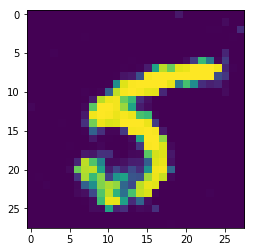

In [22]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()